In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import glob
import gc
import torch
import json
import random
import xarray as xr
import pandas as pd
import geopandas as gpd
from neuralhydrology.nh_run import start_run, eval_run
from scripts.file_manipulator import train_rewriter, test_rewriter

from neuralhydrology.evaluation import get_tester
from neuralhydrology.utils.config import Config

### Prepare data with no misses on discharge and level

In [ ]:
def xr_opener(file):
    ds = xr.open_dataset(file)
    if 'index' in ds.coords:
        ds = ds.rename({'index': 'date'})
    return ds

files = glob.glob(f'../geo_data/great_db/nc_concat/*.nc')
big_file = xr.concat([xr_opener(file) for file in files],
                     dim='gauge_id')
for gauge in big_file[['q_mm_day', 'lvl_mbs']].dropna(dim='gauge_id')['gauge_id'].values:
    ds = big_file.sel(gauge_id=gauge)
    ds.to_netcdf(f'../geo_data/great_db/nc_all_q_h/{gauge}.nc')

### Prepare name lists for used variables and read geometry

In [4]:
era_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
# q_mm_day or lvl_mbs or lvl_sm
hydro_target = 'lvl_sm'
q_h_relation = False

if (hydro_target == 'lvl_mbs') | (hydro_target == 'lvl_sm'):
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav', 'height_bs']
    nc_variable = 'nc_all_h'
    if q_h_relation:
        nc_variable = 'nc_all_q_h'
else:
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav']
    nc_variable = 'nc_all_q'

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')

### Data preparation description

#### Store in **time_series** directory every necessary file for train procedure
It stores data about predictors (**prcp_e5l, t_max_e5l, t_min_e5l**) and predicats (**q_mm_day**)

Design of the model builded up on **two** steps:

**first**: create LSTM to predict future discharge (**q_mm_day**)

**second**: create LSTM to predict future level (**lvl_mbs**) with information about predicted (**q_mm_day**) and (**prcp_e5l, t_max_e5l, t_min_e5l**)
<br/><br/>

This model allows to inference with cmip meteo data

(**precipitation_{model}, daily_maximum_near_surface_air_temperature_{model}, daily_minimum_near_surface_air_temperature_{model}**)

and previously predicted (**q_mm_day**)

In [5]:
with open('./cmip_ranks.json') as json_file:
    cmip_models = json.load(json_file)
cmip_models = list(cmip_models.values())

meteo_inputs = dict()
for model in cmip_models:
    meteo_inputs[model] = [f'precipitation_{model}',
                           f'daily_maximum_near_surface_air_temperature_{model}',
                           f'daily_minimum_near_surface_air_temperature_{model}']
# time series directory
ts_dir = Path('../geo_data/time_series')

### NeuralHydrology train data
Relies on config file. **Main** attention should be payed to **data_dir** argument
This folder is the reference to place where all required data are stored

<br><br/>
Framework automaticcally seek for **time_series** folder which should contain data **for each gauge** in desired experiment
and has all available meteo data in **.nc** format

To inlude static parameters **data_dir** should also has **attributes** folder with **.csv** file for each used gauge as an index of this file



In [ ]:
# write files for train procedure
print(f'train data for {hydro_target} with {nc_variable} initial data')
train_rewriter(era_pathes=glob.glob(
    f'../geo_data/great_db/{nc_variable}/*.nc'),
               ts_dir=ts_dir,
               hydro_target=hydro_target,
               area_index=ws_file.index,
               predictors=era_input)

### Config setup

Here we define files for **train**, **validation** and **test**

It's possible to use different gauges for certain steps of model learn procedure,

but in this example we'll use every possible gauge and split it **not in space**, but with **different time periods**

'**train_start_date**': '01/01/2009',

'**train_end_date**': '31/12/2016',

'**validation_start_date**': '01/01/2017',

'**validation_end_date**': '31/12/2018',

'**test_start_date**': '01/01/2019',

'**test_end_date**': '31/12/2020'


In [ ]:
# define variables require to perform hindcast
gauges = [file.split('/')[-1][:-3] for
          file in glob.glob(f'{ts_dir}/*.nc')]
random.shuffle(gauges)
gauge_size = len(gauges)

# with open('./every_basin.txt', 'w') as the_file:
#     for gauge_name in gauges:
#         the_file.write(f'{gauge_name}\n')

train_gauges = gauges[
    :int(len(gauges) * 0.8)]
with open('./basins_train.txt', 'w') as the_file:
    for gauge_name in train_gauges:
        the_file.write(f'{gauge_name}\n')

val_gauges = gauges[
    int(gauge_size * 0.8):int(gauge_size * 0.8) + int(gauge_size * 0.1)]
with open('./basins_val.txt', 'w') as the_file:
    for gauge_name in val_gauges:
        the_file.write(f'{gauge_name}\n')

test_gauges = gauges[
    int(gauge_size * 0.8) + int(gauge_size * 0.1):]
with open('./basins_test.txt', 'w') as the_file:
    for gauge_name in test_gauges:
        the_file.write(f'{gauge_name}\n')

cfg = Config(Path('./model_config.yml'))
# base model type [cudalstm, customlstm, ealstm, embcudalstm, mtslstm, gru, transformer]
# (has to match the if statement in modelzoo/__init__.py)
model_name = 'cudalstm'
cfg.update_config(yml_path_or_dict={
    # define storage and experiment
    'experiment_name': f'{model_name}_{hydro_target}',
    'model': f'{model_name}',
    'run_dir': './',
    'data_dir': '../geo_data/',
    # define inner parameters
    'static_attributes': static_parameters,
    'dynamic_inputs': era_input,
    # 'hindcast_inputs': era_input,
    # 'forecast_inputs': era_input,
    'target_variables': [hydro_target],
    # 'dynamics_embedding': {'type': 'fc', 'hiddens': [128, 64, 256],
    #                       'activation': 'tanh', 'dropout': 0.2},
    # 'statics_embedding': {'type': 'fc', 'hiddens': [128, 64, 256],
    #                      'activation': 'tanh', 'dropout': 0.2},    
    # define files with gauge data
    'train_basin_file': './every_basin.txt',
    'validate_n_random_basins': gauge_size,
    'validation_basin_file': './every_basin.txt',
    'test_basin_file': './every_basin.txt',
    # define time periods
    # 'seq_length': 14,
    # 'forecast_seq_length': 10,
    'train_start_date': '01/01/2009',
    'train_end_date': '31/12/2016',
    'validation_start_date': '01/01/2017',
    'validation_end_date': '31/12/2018',
    'test_start_date': '01/01/2019',
    'test_end_date': '31/12/2020'})
cfg.dump_config(folder=Path('./launch_configs'),
                filename=f'{model_name}_{hydro_target}.yml')

In [ ]:
if torch.cuda.is_available():
    start_run(config_file=Path(
        f'./launch_configs/{model_name}_{hydro_target}.yml'))

### Test setup

Main idea is to just replace meteo input from **era** with the **cmip's**

So the learned weights of **era** model will be used with **cmip's** data


We rewrite files in **time_series** directory 
with data for **desired** gauges and new **dynamic_inputs** from selected **cmip**

In [ ]:
meteo_inputs

In [19]:
# get cmips
cmip_path = '../geo_data/cmip_concat_new/ssp_2_4_5/'
obs_pathes = glob.glob('../geo_data/great_db/nc_all_q_h/*.nc')
# get gauge id's
with open('./delete_me_test.txt', 'r') as f:
    res = [line.strip() for line in f]
f.close()

# write files for test procedure
print(f'test data for {hydro_target} with {nc_variable} initial data')
test_rewriter(train_with_obs=obs_pathes,
              cmip_storage=cmip_path,
              test_index=res,
              predictors=meteo_inputs['ec_earth3_veg_lr'],
              era_names=era_input,
              ts_dir=ts_dir)

test data for lvl_sm with nc_all_h initial data


Update config that we get from **train** procedure

with new **dynamic_iputs** from selected **cmip** and and new **test_start_date** and **test_end_date**

In [20]:
cfg = Config(Path('./model_runs/cudalstm_lvl_sm_0809_073042/config.yml'))
# cfg.update_config(yml_path_or_dict = {'test_basin_file': '/workspaces/my_dissertation/neural_forecast/delete_me_test.txt',
#                                       'test_start_date': '01/01/2018',
#                                       'test_end_date': '31/12/2020',
#                                       'dynamic_inputs': meteo_inputs['ec_earth3_veg_lr']})
cfg.update_config(yml_path_or_dict = {'test_basin_file': '/workspaces/my_dissertation/neural_forecast/delete_me_test.txt',
                                      'test_start_date': '01/01/2018',
                                      'test_end_date': '31/12/2025'})


Run **test** on selected gauge

In [21]:
tester = get_tester(cfg=cfg,
                    run_dir=cfg.run_dir,
                    period = 'test',
                    init_model=True)
pred_results = tester.evaluate(epoch=22, save_results=False)

# Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


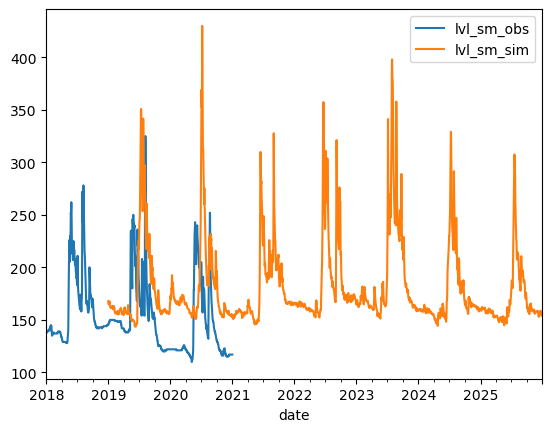

In [23]:
pred_results['1151']['1D']['xr'].to_dataframe().droplevel(1).plot();